# SpaCeNet

This is a quick introduction on how to use `SpaCeNet`.

Let's first load the necessary packages and our data.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.ticker import FixedLocator, FuncFormatter
import numpy as np
import pickle
import torch

from SpaCeNet.model import SpaCeNet
from SpaCeNet.utils import AUC, Theta, get_device

In [2]:
file_name = "simulated_data.pickle"

with open(file_name, "rb") as f:
    data = pickle.load(f)

X_mat = data["X_mat"]
coord_mat = data["coord_mat"]
Omega_mat_true = data["Omega_mat_true"]
Drho_mat_true = data["Drho_mat_true"]
Phi_mat_true = data["Phi_mat_true"]

We use 100 samples with 1000 observations and 20 variables each. From the 3-dimensional coordinates in `coord_mat` we can construct our $\Theta^{(\cdot)}$ where we choose an expansion order `L=3`.

In [3]:
Theta_tens = Theta(coords=coord_mat, L=3)

From these `numpy`-arrays we construct the needed `torch`-tensors. It is important to use data type `torch.float64` / `torch.double`. Using cuda can significantly speed up the computations.

In [4]:
device = get_device(use_cuda=False)
X_mat = torch.tensor(X_mat, dtype=torch.double, device=device)
Theta_tens = torch.tensor(Theta_tens, dtype=torch.double, device=device)

Info: will use cpu!


Finally we can build and fit our model.

In [5]:
alpha = 0.2
beta = 0.02
optimizer_options = dict(
    verbose=True,
    momentum=0.9,
    max_iter=1_000,
    step_size=1e-6,
    eps=1e-5
)

model = SpaCeNet(
    alpha=alpha,
    beta=beta,
    device=device,
    optimizer_options=optimizer_options
)
model.fit(X_mat, Theta_tens)

Omega_mat = model.Omega_mat.cpu().numpy()
Drho_tens = model.Drho_tens.cpu().numpy()
losses = model.losses.cpu().numpy()

exit after iter 23, projection_loss = 2565383.5137353, relative_loss_change = 5.10e-06


All that's left to do is to take a look at our losses and to compare our estimated parameters to the true ones.

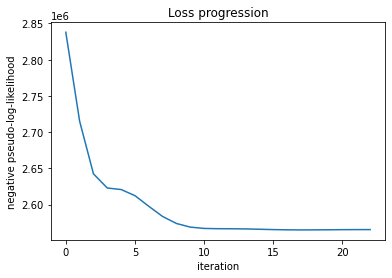

In [6]:

plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("negative pseudo-log-likelihood")
plt.title("Loss progression")
plt.show()

True parameters


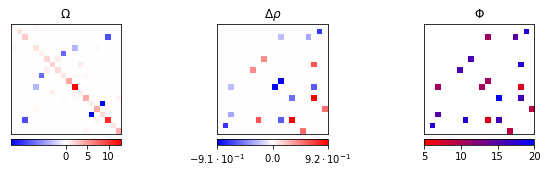

In [7]:
def format_func(x, pos):
  mantissa, pot = f"{x:.1e}".split("e")
  pot = int(pot)
  if pot == 0:
    return f"${mantissa}$"
  return f"${mantissa} \\cdot 10^{{{pot}}}$"


formatter = FuncFormatter(format_func)


# True parameters
print("True parameters")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10.5, 2.5))

Omega_true_norm = TwoSlopeNorm(vmin=Omega_mat_true.min(), vcenter=0, vmax=Omega_mat_true.max())
Drho_true_norm = TwoSlopeNorm(vmin=Drho_mat_true.min(), vcenter=0, vmax=Drho_mat_true.max())
Phi_cmap = LinearSegmentedColormap.from_list("my_cmap", [(1, 0, 0), (0, 0, 1)], N=200)

img1 = ax1.imshow(Omega_mat_true, cmap="bwr", norm=Omega_true_norm)
ax1.set_title(r"$\Omega$")

fig.colorbar(img1, ax=ax1, location="bottom", pad=0.04, shrink = 0.64)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

img2 = ax2.imshow(Drho_mat_true, cmap="bwr", norm=Drho_true_norm)
ax2.set_title(r"$\Delta\rho$")
fig.colorbar(img2, ax=ax2, location="bottom", pad=0.04, shrink=0.64, format=formatter, ticks=FixedLocator([np.min(Drho_mat_true), 0, np.max(Drho_mat_true)]))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

img3 = ax3.imshow(np.where(Phi_mat_true == 0, float("nan"), Phi_mat_true), cmap=Phi_cmap, vmin=5., vmax=20.)
ax3.set_title(r"$\Phi$")
fig.colorbar(img3, ax=ax3, location="bottom", pad=0.04, shrink=0.64)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
plt.show()

Estimated parameters


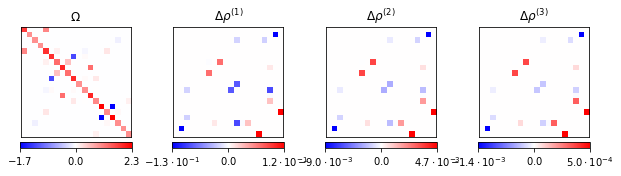

In [8]:
# Estimated parameters
print("Estimated parameters")
fig, axes = plt.subplots(1, 1 + model.L, figsize=(10.5, 2.5))

for l in range(-1, model.L):
  ax = axes[l + 1]
  if l == -1:
    matrix = Omega_mat
    ax.set_title(r"$\Omega$")
  else:
    matrix = Drho_tens[l]
    ax.set_title(r"$\Delta\rho^{(" + f"{l + 1})}}$")

  
  min_val = matrix.min()
  max_val = matrix.max()
  norm = TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=max_val)
  img = ax.imshow(matrix, cmap="bwr", norm=norm)
  fig.colorbar(img, ax=ax, location="bottom", pad=0.04, shrink=0.88, format=formatter, ticks=FixedLocator([min_val, 0, max_val]))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.show()

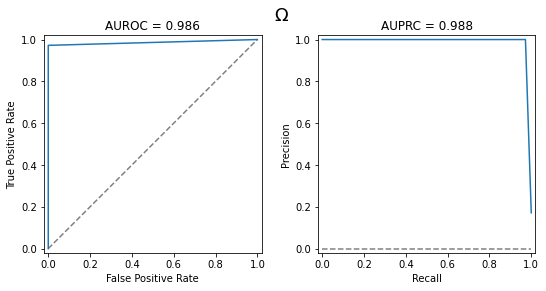

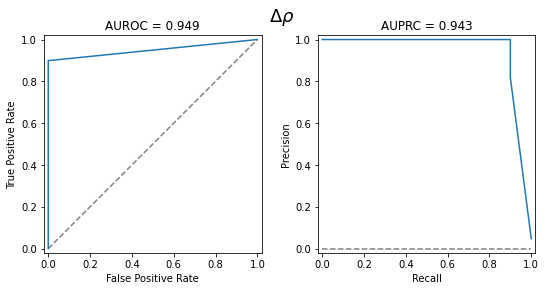

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle(r"$\Omega$", fontsize=18)
AUC(Omega_mat, Omega_mat_true, plot=True, axes=(ax1, ax2))
plt.show()

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle(r"$\Delta\rho$", fontsize=18)
AUC(Drho_tens, Drho_mat_true, plot=True, axes=(ax3, ax4))
plt.show()